# Lesson 2 : LangGraph Components

In [ ]:
from dotenv import load_dotenv
_ = load_dotenv()
# open ai key

In [ ]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
# define the agenst state
import operator
# langchain messages
# human, ai and system messages
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_openai import ChatOpenAI
# consistent calls, can change the llms
from langchain_community.tools.tavily_search import TavilySearchResults

## my notes
## Langchain prompts
- a string with formattable content
- the contents are from user inputs
- prompts can be found in langchain hub

## tools
- tavily tool: search
- 100 of tools

## graphs
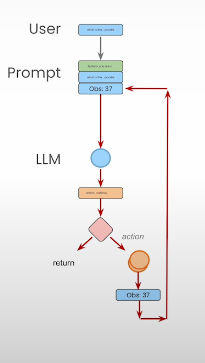
- academic papers the agent workflows are represented as graphs
- one state to another
- 3 major components of line graph

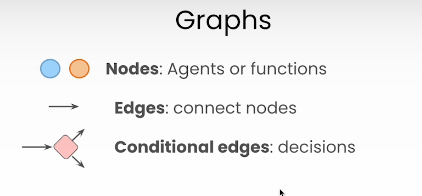

- flow
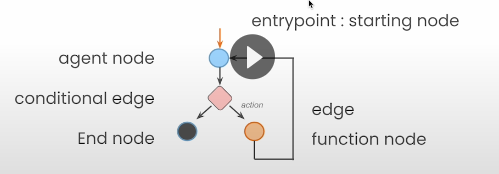

- The state of the agent is tracked over the time
- agent state
- local to the graph -> persistence to the graph

In [ ]:
tool = TavilySearchResults(max_results=4) #increased number of results
print(type(tool))
print(tool.name)

> If you are not familiar with python typing annotation, you can refer to the [python documents](https://docs.python.org/3/library/typing.html).

In [ ]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

# AnyMessage is a langchain message
# operator.add ensures the message is appended all the time when a new message comes


> Note: in `take_action` below, some logic was added to cover the case that the LLM returned a non-existent tool name. Even with function calling, LLMs can still occasionally hallucinate. Note that all that is done is instructing the LLM to try again! An advantage of an agentic organization.

In [ ]:
class Agent:

    def __init__(self, model, tools, system=""):
        self.system = system
        # save system message
        graph = StateGraph(AgentState)
        # initalize the graph
        graph.add_node("llm", self.call_openai)
        # llm node, need to pass the function
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges(
            "llm", # the edge starts (entry point)
            self.exists_action, # where to go after that
            {True: "action", False: END} # condition, where to go if ture and false
        )
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")
        self.graph = graph.compile()
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)

    def exists_action(self, state: AgentState):
        result = state['messages'][-1]
        return len(result.tool_calls) > 0

    def call_openai(self, state: AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {'messages': [message]}

    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            if not t['name'] in self.tools:      # check for bad tool name from LLM
                print("\n ....bad tool name....")
                result = "bad tool name, retry"  # instruct LLM to retry if bad
            else:
                result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Back to the model!")
        return {'messages': results}

In [ ]:
prompt = """You are a smart research assistant. Use the search engine to look up information. \
You are allowed to make multiple calls (either together or in sequence). \
Only look up information when you are sure of what you want. \
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""

model = ChatOpenAI(model="gpt-3.5-turbo")  #reduce inference cost
abot = Agent(model, [tool], system=prompt)

In [ ]:
from IPython.display import Image

Image(abot.graph.get_graph().draw_png())

In [ ]:
messages = [HumanMessage(content="What is the weather in sf?")]
result = abot.graph.invoke({"messages": messages})

In [ ]:
result

In [ ]:
result['messages'][-1].content

In [ ]:
messages = [HumanMessage(content="What is the weather in SF and LA?")]
result = abot.graph.invoke({"messages": messages})

In [ ]:
result['messages'][-1].content

In [ ]:
# Note, the query was modified to produce more consistent results. 
# Results may vary per run and over time as search information and models change.

query = "Who won the super bowl in 2024? In what state is the winning team headquarters located? \
What is the GDP of that state? Answer each question." 
messages = [HumanMessage(content=query)]

model = ChatOpenAI(model="gpt-4o")  # requires more advanced model
abot = Agent(model, [tool], system=prompt)
result = abot.graph.invoke({"messages": messages})

In [ ]:
print(result['messages'][-1].content)